# Benchmark for d-wave

In [1]:
from typing import Optional

In [2]:
import matplotlib.pylab as plt
import seaborn as sns
import os
import numpy as np
import pandas as pd

In [3]:
from networkx import Graph
from networkx.algorithms.approximation import min_weighted_dominating_set

In [4]:
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite

In [5]:
dwave_config = {
    # "solver": "DW_2000Q_5",
    "annealing_time": 100,  # integer microseconds [1, 2000]
    "answer_mode": "raw",
    "auto_scale": True,
    "num_reads": 1000,  # raw will dump out all results
    "num_spin_reversal_transforms": 10,  # ask Travis what this is
}
sampler = DWaveSampler(solver="DW_2000Q_5")
embed = EmbeddingComposite(sampler)

In [6]:
from qlp.mds import graph_tools as gt
from qlp.mds.qubo import get_mds_qubo
from qlp.mds.solver import classical_search

In [7]:
def agg_res(df: pd.DataFrame, n_nodes: Optional[int] = None) -> pd.DataFrame:
    """Aggregate solution columns, find probablity and sort df
    """
    cols = [col for col in df.columns if str(col).isnumeric()]
    dist = (
        df.groupby(cols)
        .agg({"num_occurrences": "count", "energy": "mean"})
        .sort_values("num_occurrences", ascending=False)
    )
    if n_nodes is not None:
        not_cols = [col for col in cols if int(col) >= n_nodes]
        dist = dist.reset_index(not_cols).drop(columns=not_cols)

    dist["p"] = dist["num_occurrences"] / dist["num_occurrences"].sum()
    return dist

# Examples

## Most simple graph with unique sol

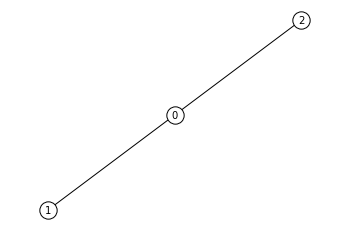

In [8]:
graph = {(1, 0,), (2, 0)}

gt.get_plot(graph)
plt.show()

In [9]:
qubo = get_mds_qubo(graph)
qubo.todense()

matrix([[-11,   8,   8,  -8, -16,  -8,  -8],
        [  8,  -7,   4,  -8, -16,  -8,   0],
        [  8,   4,  -7,  -8, -16,   0,  -8],
        [  0,   0,   0,  12,   8,   0,   0],
        [  0,   0,   0,   8,  32,   0,   0],
        [  0,   0,   0,   0,   0,  12,   0],
        [  0,   0,   0,   0,   0,   0,  12]])

### Solve problem on D-Wave

100%|██████████| 128/128 [00:00<00:00, 7772.96it/s]


Brute force search classical minimal energy -11


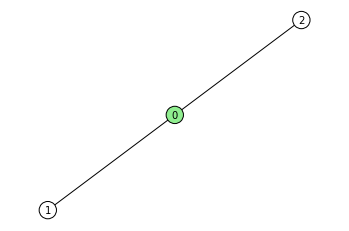

In [10]:
e, nodes = classical_search(qubo)
print("Brute force search classical minimal energy", e)
gt.get_plot(graph, nodes[0])
plt.show()

Apparently I had to manually rescale the QUBO to solve the right problem. It seems like min(Q) > -0.8 is a good setting

https://docs.dwavesys.com/docs/latest/c_qpu_3.html#adjusting-the-problem-scale

In [11]:
q_min = np.array(list(qubo.values())).min()
fact = np.abs(q_min) * 0.8
print(fact)
qubo_rescaled = qubo / fact

12.8


Convert to dict 

In [12]:
file_name = "graph_res_1-0-9.csv"
quobo_dict = {
    key: val for key, val in zip(qubo_rescaled.keys(), qubo_rescaled.values())
}

if os.path.exists(file_name):
    print("Reading data")
    raw = pd.read_csv(file_name)
else:
    print("Submitting")
    result = embed.sample_qubo(quobo_dict, **dwave_config)
    raw = result.to_pandas_dataframe()
    raw.to_csv(path_or_buf=file_name, index=False)

df = raw.sort_values("energy", ascending=True)
df["energy"] *= fact
df.head()

Reading data


,0,1,2,3,4,5,6,chain_break_fraction,energy,num_occurrences
446,1,0,0,0,0,0,0,0.0,-11.0,1
414,1,0,0,0,0,0,0,0.0,-11.0,1
405,1,0,0,0,0,0,0,0.0,-11.0,1
400,1,0,0,0,0,0,0,0.0,-11.0,1
398,1,0,0,0,0,0,0,0.0,-11.0,1


In [13]:
dist = agg_res(df, n_nodes=3)
dist.head()

num_occurrences  energy      p
0 1 2                                
1 0 0              292   -11.0  0.292
0 1 1              145   -10.0  0.145
1 1 0              141   -10.0  0.141
  0 1              131   -10.0  0.131
  1 1               96    -9.0  0.096

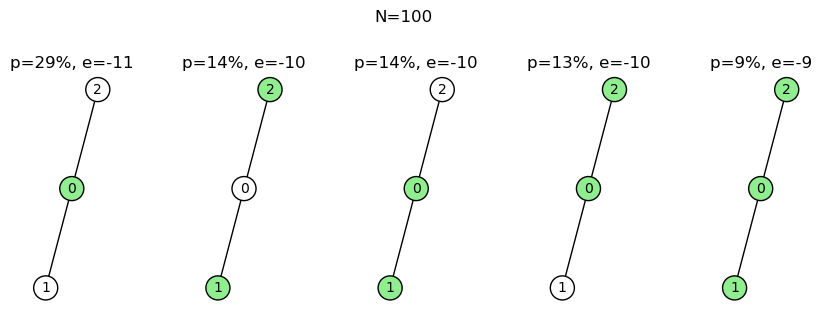

In [14]:
n_cols = 5
first_five = dist.head(n=n_cols)

fig, axs = plt.subplots(ncols=n_cols, nrows=1, squeeze=False, figsize=(10, 3), dpi=100)

for ind, res, ax in zip(first_five.index, first_five.to_dict("records"), axs.flatten()):
    color_nodes = set([i for i, v in enumerate(ind) if v == 1])
    gt.get_plot_mpl(graph, color_nodes=color_nodes, ax=ax)
    p, e = res["p"], res["energy"]
    ax.set_title(f"p={int(p*100):d}%, e={int(e)}")

fig.suptitle("N=100", y=1.1)

plt.subplots_adjust(wspace=1.0)
plt.show()

## More complicated graph

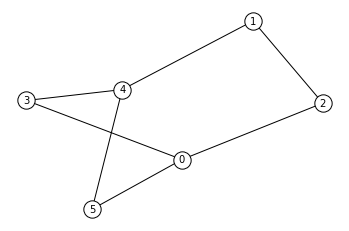

In [15]:
graph = {(0, 2), (0, 3), (0, 5), (1, 2), (1, 4), (3, 4), (4, 5)}
gt.get_plot(graph)
plt.show()

In [16]:
qubo = get_mds_qubo(graph)

In [17]:
q_min = np.array(list(qubo.values())).min()
fact = np.abs(q_min) * 0.8
print(fact)
qubo_rescaled = qubo / fact

22.400000000000002


In [18]:
file_name = "graph_res_6.csv"
quobo_dict = {
    key: val for key, val in zip(qubo_rescaled.keys(), qubo_rescaled.values())
}

if os.path.exists(file_name):
    print("Reading data")
    raw = pd.read_csv(file_name)
else:
    print("Submitting")
    result = embed.sample_qubo(quobo_dict, **dwave_config)
    raw = result.to_pandas_dataframe()
    raw.to_csv(path_or_buf=file_name, index=False)

df = raw.sort_values("energy", ascending=True)
df["energy"] *= fact
df.head()

Reading data


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,chain_break_fraction,energy,num_occurrences
66,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,-40.0,1
37,1,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,1,0,0.0,-40.0,1
58,1,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,1,0,0.0,-40.0,1
99,1,0,0,0,1,1,1,0,0,0,...,0,1,0,1,0,0,1,0.0,-39.0,1
24,0,1,0,1,0,1,1,0,0,0,...,0,0,0,0,1,0,0,0.0,-39.0,1


In [19]:
dist = agg_res(df, n_nodes=6).sort_values("energy")
dist.head()

num_occurrences  energy     p
0 1 2 3 4 5                               
1 0 0 0 1 0                2   -40.0  0.02
  1 0 0 0 0                1   -40.0  0.01
  0 0 0 1 1                1   -39.0  0.01
      1 1 0                1   -39.0  0.01
0 1 0 1 0 1                1   -39.0  0.01

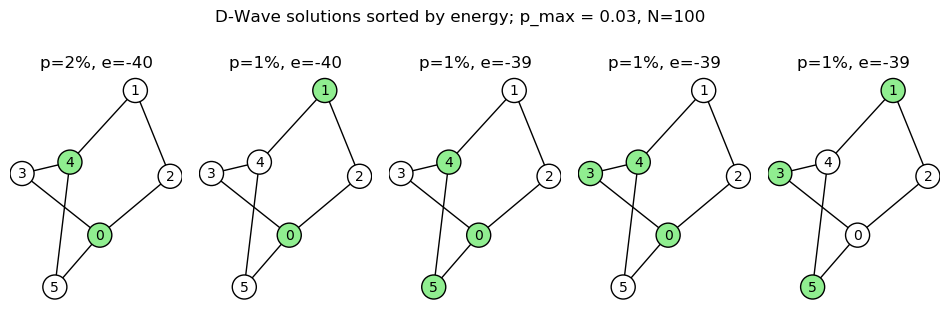

In [20]:
n_cols = 5
first_five = dist.head(n=n_cols)

fig, axs = plt.subplots(ncols=n_cols, nrows=1, squeeze=False, figsize=(12, 3), dpi=100)

for ind, res, ax in zip(first_five.index, first_five.to_dict("records"), axs.flatten()):
    color_nodes = set([i for i, v in enumerate(ind) if v == 1])
    gt.get_plot_mpl(graph, color_nodes=color_nodes, ax=ax)
    p, e = res["p"], res["energy"]
    ax.set_title(f"p={int(p*100):d}%, e={int(e)}")

fig.suptitle(f"D-Wave solutions sorted by energy; p_max = {dist.p.max()}, N=100", y=1.1)

plt.subplots_adjust(wspace=0.1)
plt.show()

## Presentation graph

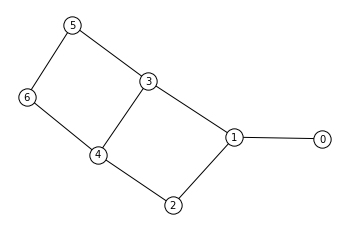

In [21]:
graph = {(0, 1), (1, 2), (1, 3), (2, 4), (3, 4), (3, 5), (4, 6), (6, 5)}
nodes = set([i for i, _ in graph] + [i for _, i in graph])
n_nodes = len(nodes)

gt.get_plot(graph)
plt.show()

In [22]:
qubo = get_mds_qubo(graph)

In [23]:
q_min = np.array(list(qubo.values())).min()
fact = np.abs(q_min) / 0.8
print(fact)
qubo_rescaled = qubo / fact

40.0


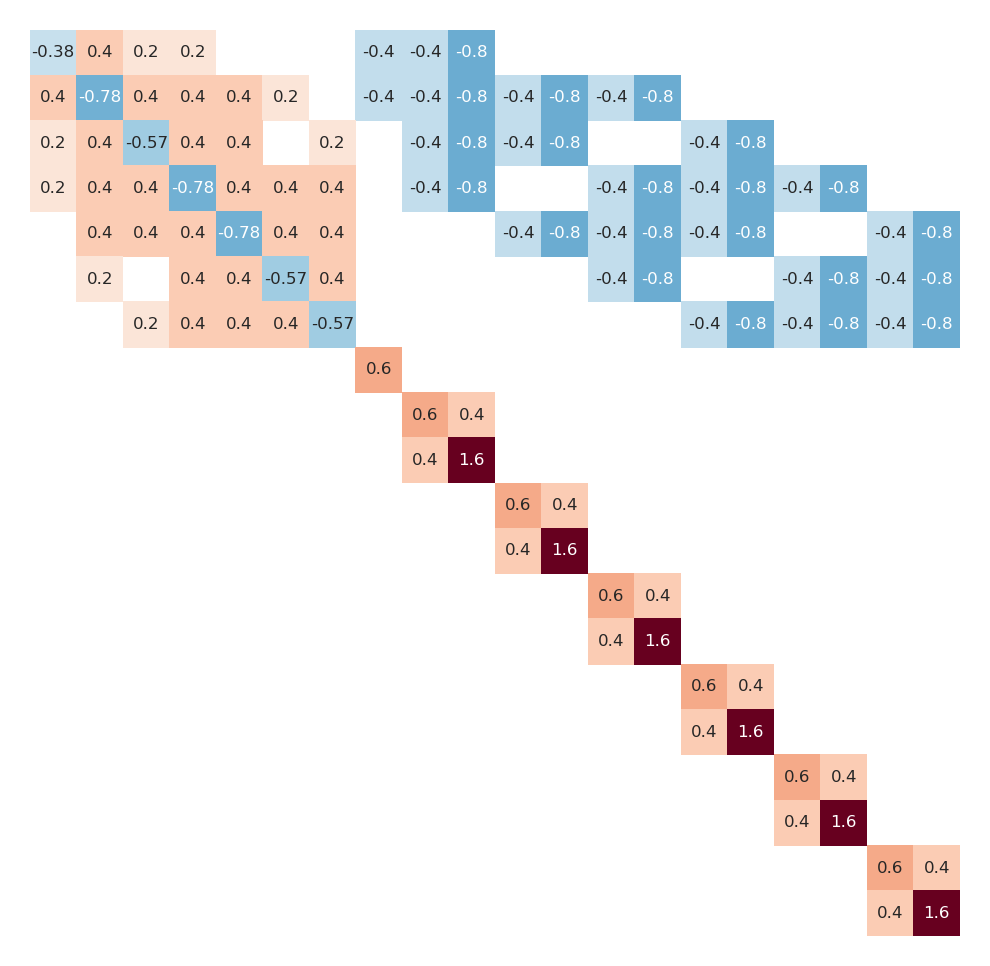

In [24]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=300)

m = qubo_rescaled.todense()
vmax = np.abs(m).max()

sns.heatmap(
    m,
    annot=True,
    ax=ax,
    annot_kws={"fontsize": 4},
    cmap="RdBu_r",
    vmin=-vmax,
    vmax=vmax,
    mask=m == 0,
    cbar=False,
)
ax.set_yticks([])
ax.set_xticks([])
ax.set_xlim(0, 20)
ax.set_ylim(20, 0)

plt.show()

In [25]:
file_name = "graph_res_pres-1000.csv"
quobo_dict = {
    key: val for key, val in zip(qubo_rescaled.keys(), qubo_rescaled.values())
}

if os.path.exists(file_name):
    print("Reading data")
    raw = pd.read_csv(file_name)
else:
    print("Submitting")
    result = embed.sample_qubo(quobo_dict, **dwave_config)
    raw = result.to_pandas_dataframe()
    raw.to_csv(path_or_buf=file_name, index=False)

df = raw.sort_values("energy", ascending=True)
df["energy"] *= fact
df.head()

Reading data


,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,chain_break_fraction,energy,num_occurrences
695,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0.0,-54.0,1
226,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0.0,-54.0,1
838,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0.0,-54.0,1
763,0,1,0,1,0,1,0,0,1,0,...,1,0,0,1,0,0,0,0.0,-53.0,1
705,0,1,0,1,0,0,1,0,1,0,...,0,1,0,1,0,0,0,0.0,-53.0,1


In [ ]:
dist = agg_res(df, n_nodes=n_nodes).sort_values("energy")
dist.head()

In [ ]:
df.shape[0]

In [ ]:
n_cols = 5
first_five = dist.head(n=n_cols)

fig, axs = plt.subplots(ncols=n_cols, nrows=1, squeeze=False, figsize=(12, 3), dpi=100)

for ind, res, ax in zip(first_five.index, first_five.to_dict("records"), axs.flatten()):
    color_nodes = set([i for i, v in enumerate(ind) if v == 1])
    gt.get_plot_mpl(graph, color_nodes=color_nodes, ax=ax)
    p, e, n = res["p"], res["energy"], res["num_occurrences"]
    ax.set_title(f"n={n}, g={len(color_nodes)}")

fig.suptitle(
    f"D-Wave solutions sorted by energy;"
    f" N={df.shape[0]},"
    f" n_max = {dist.num_occurrences.max()},"
    f" e_min={int(df.energy.min())}",
    y=1.1,
)

plt.subplots_adjust(wspace=0.1)
plt.show()